# Instrument response modelling

Demonstration of how to build and use an instrument response to compare a model with data.

In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import h5py

from instrument_response.toy_simulation import ToySimulation
from instrument_response.detector import Response

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Forward model


In [10]:
# Define inputs
power_law_index = 2.2
min_energy = 1 # TeV
max_energy = 100 # TeV

simulation = ToySimulation(power_law_index, min_energy, max_energy)

In [11]:
# Run for large number of particles to generate response
N = int(1e4)
simulation.run(N)
#simulation.save('output/response_sim.h5')
simulation.save('output/data.h5')

In [12]:
# Read in output
with h5py.File('output/data.h5', 'r') as f:
    true_energy = f['true_energy'].value
    N_secondaries = f['number_of_secondaries'].value
    N_det_secondaries = f['number_of_detected_secondaries'].value
    detected_energy = f['detected_energy'].value
    initial_energy = f['initial_energy'].value

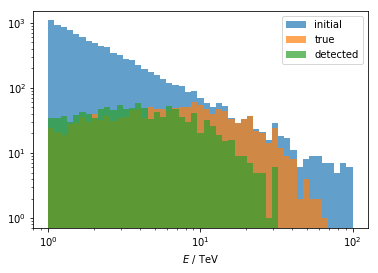

In [13]:
# Plot
bins = np.logspace(np.log(min_energy), np.log(max_energy), base=np.e)

fig, ax = plt.subplots();
ax.hist(initial_energy, bins=bins, alpha=0.7, label='initial')
ax.hist(true_energy, bins=bins, alpha=0.7, label='true');
ax.hist(detected_energy, bins=bins, alpha=0.7, label='detected');
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / TeV')
ax.legend();

## Response matrix

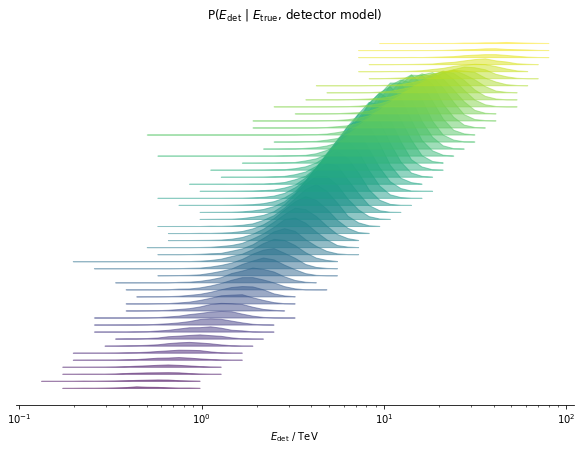

In [14]:
# Read in info from file
with h5py.File('output/response_sim.h5', 'r') as f:
    initial_energy = f['initial_energy'].value
    true_energy = f['true_energy'].value
    detected_energy = f['detected_energy'].value
    Aeff_max = f['effective_area_maximum'].value

nbins_true = 50 
nbins_detected = 50
response = Response(initial_energy, true_energy, detected_energy, 
                    nbins_true, nbins_detected, Aeff_max)
response.show()

## Data

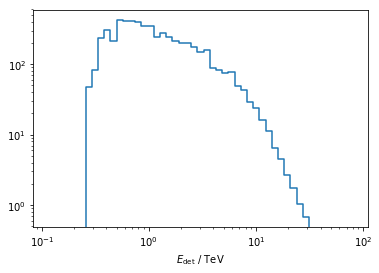

In [23]:
with h5py.File('output/data.h5', 'r') as f:
    detected_energy = f['detected_energy'].value
    true_energy = f['true_energy'].value
    initial_energy = f['initial_energy'].value

channels = response.detected_energy_bins
dE = np.diff(channels)

# convert energies to rate
dN_dt, _ = np.histogram(detected_energy, bins=channels)
dN_dtdE = dN_dt / dE

fig, ax = plt.subplots()
ax.step(channels[:-1], dN_dtdE, where='pre')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{det}$ / TeV');

## Forward folding

In [24]:
from instrument_response.power_law import BoundedPowerLaw
power_law = BoundedPowerLaw(2.2, 1.0, 100)

In [25]:
norm=1e4
def differential_flux(norm, e):
    return norm * power_law.pdf(e)

# integral of the differential flux (simpson's rule)
def integral(e1, e2):
    return (e2 - e1) / 6.0 * (differential_flux(norm,e1) + 4 * differential_flux(norm, (e1 + e2) / 2.0)+ differential_flux(norm, e2))

# true photon fluxes integrated over the photon bins of the response
# dN/dtdA
true_fluxes = integral(response.true_energy_bins[:-1], 
                       response.true_energy_bins[1:])  

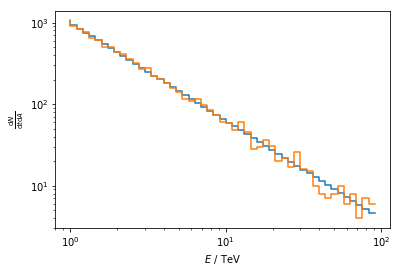

In [26]:
# Plot the model
fig, ax = plt.subplots()

ax.step(response.true_energy_bins[:-1], true_fluxes, where='pre')

# compare with truth from MC
true_rate, _ = np.histogram(initial_energy, bins=response.true_energy_bins) #dN/dtdA
ax.step(response.true_energy_bins[:-1], true_rate) #dN/dtdA

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$E$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d}t \mathrm{d}A}$');

In [27]:
dN_dt_model = np.dot(true_fluxes, response.matrix) # dN/dtdA . dA -> dN/dt 

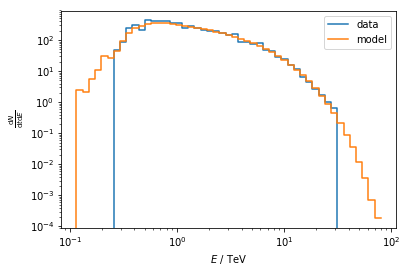

In [28]:
fig, ax = plt.subplots()

dE = np.diff(response.detected_energy_bins)
ax.step(channels[:-1], dN_dtdE, where='pre', label='data')
ax.step(channels[:-1], dN_dt_model/dE, where='pre', label='model')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}t\mathrm{d}E}$')
ax.legend();